In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import numpy as np
import allel
import itertools
import os
from subprocess import call
from tqdm import tqdm, trange
from scipy.stats import chi2_contingency

import statsmodels.api as sm
import statsmodels.formula.api as smf

#allows multiple outputs: all, last, last_expr(default), none, last_expr_or_assign
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign" 

#### Step 1: make contig list

In [2]:
#First make contig list
contig_list = pd.read_table('/data3/arshad_PNAS_data/For_Tae/polistes_contig.txt', sep=',', header=None)
contig_list.rename(columns ={0:"ID", 1:"Length"}, inplace =True)
contig_list.head(5)

,ID,Length
0,##contig=<ID=PdomSCFr1.2-0001,length=7126315>
1,##contig=<ID=PdomSCFr1.2-0002,length=5803805>
2,##contig=<ID=PdomSCFr1.2-0003,length=6052460>
3,##contig=<ID=PdomSCFr1.2-0004,length=5611376>
4,##contig=<ID=PdomSCFr1.2-0005,length=4881697>


In [3]:
contig_list['ID'] = contig_list['ID'].str.split('ID=').str.get(1)
contig_list['Length'] = contig_list['Length'].str.split('=').str.get(1)
contig_list['Length'] = contig_list['Length'].str.split('>').str.get(0).astype(int)
contig_list.head(3)
contig_list.dtypes

ID        object
Length     int64
dtype: object

In [4]:
contig_list['Length'].sort_values(ascending=False);

In [5]:
contig_plus10k = contig_list[contig_list['Length'] > 100000] #remove anything smaller than single window
contig_plus10k['Length'].sort_values();

In [6]:
#Output the File
#Do it once! only once!
#contig_plus10k['ID'].to_csv('/home/taeyoon/VcfFiles/LdByWindow/pol_contig_list.txt', header=False, index=False)

#### Step 2: Chop by 100k window

In [7]:
#this step uses tabix
#this first requires turning vcf to vcf.gz
# bgzip your.vcf
# tabix -p vcf your.vcf.gz <- this makes index
# tabix your.vcf.gz chr1:10,000,000-20,000,000

#modify chopbywindow.script.txt (is in VcfFiles/LdByWindows)
#this chops them into 100k windows, deposites the output into set directory

#for window of LD test in chopped files, going with 60 for safe measure.
#No MAF cut as per original and purpose
#polistes has to run in geno-r2 (NOT hap-r2)


#### Step 3: Calculating Mean-Median R2 per Window

In [8]:
#take all files and make one dataframe
ld_r2 = []

path_folder = '/data3/TaeFile/Pol_HapLd/'

for file in tqdm(os.listdir(path_folder), total=len(path_folder)):
    window = file.split('_headered')[0]
    df = pd.read_csv(f'{path_folder}/{file}', sep='\t')
    mean_r2 = df['R^2'].mean()
    median_r2 = df['R^2'].median()
    ld_r2.append([window, mean_r2, median_r2])

#destination of the final file is in home directory = windowed_LD.csv

2096it [00:08, 247.10it/s]                      


In [9]:
df = pd.DataFrame(ld_r2, columns = ['ID', 'r2_mean', 'r2_median'])
display(df.head())

,ID,r2_mean,r2_median
0,PdomSCFr1.2-0173_100000,0.246808,0.079546
1,PdomSCFr1.2-0115_200000,0.251666,0.092593
2,PdomSCFr1.2-0030_300000,0.396516,0.200820
3,PdomSCFr1.2-0025_2000000,0.335720,0.111111
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365


#### Step 4: Making the Master Dataframe

In [10]:
#AA caller, based on frequency.
#common, high frequency seen as reference/ancestral
#rarer, low frequency seen as alternative/derived
def AA_caller(frequency, reference, alternative):
    if (frequency > 0.5):
        return alternative
    elif (frequency < 0.5):
        return reference
    else:
        return np.nan

In [11]:
#Mutation direction function "strength_classifier"
strong_bases= ['G', 'C']
weak_bases= ['A', 'T']

def strength_classifier(ancestor, derived):
    if (ancestor in strong_bases) and (derived in weak_bases):
        return 'SW'
    elif (ancestor in weak_bases) and (derived in strong_bases):
        return 'WS'
    else:
        return 'NN'

In [12]:
#Define frequency of the Derived State, the mutation
#if ALT = Derived, keep the original AF, which describes the frequency of the ALT
#if REF = Derived, use 1 - AF

def mutation_frequency (Derived, ALT, AF):
    if Derived == ALT: #this means derived is ALT, which AF is associated with
        return AF
    if Derived != ALT: #this means dervied is REF, which is inversely associated with AF
        return (1-AF)
    else:
        return 'Error'

In [13]:
#split_bar = Trimmed_table(Trimmed_table['Alt_Freq' == 0.1], Trimmed_table['Strength' == 'SW'])
#Trimmed_table['Strength'].value_counts().plot(kind='bar')
#Ancestry based on allele frequency

def barcoder(strength, frequency):
    if (strength == 'SW') and (frequency <= 0.1): #make it less or equal, to be generalizable for different data.
        return 'SW-Rare'
    elif (strength == 'SW') and (0.25 <= frequency <= 0.5):
        return 'SW-Common'
    elif (strength == 'WS') and (frequency <= 0.1):
        return 'WS-Rare'
    elif (strength == 'WS') and (0.25 <= frequency <= 0.5):
        return 'WS-Common'
    else:
        return 'NaN'

    '''Rare mutation defined as something with frequency of 0.1,
        Common mutation is something that is found more than 0.5 of the time.'''

In [14]:
#execute everything
chopped_polistes = []

path_folder_2 = '/data3/TaeFile/Pol_HeaderedVcf'

for file in tqdm(os.listdir(path_folder_2), total=len(path_folder_2)):
    window = file.split('_headered')[0]
    
    # Process the file
    df_basket = pd.read_table(f'{path_folder_2}/{file}', sep ='\t', header=None, comment='#')
    df_basket.rename(columns={
        0:"SCAF", 
        1:"POS", 
        2:"Id", 
        3:"REF", 
        4:"ALT", 
        5:"quality", 
        6:"filter", 
        7:"INFO", 
        8:"header", 
        9:"1", 10:"10", 11:"11", 12:"2b", 13:"3", 14:"4", 15:"5", 16:"6", 17:"7", 18:"8"}, inplace=True)
    
    column_picks= ["SCAF", "POS", "REF", "ALT", "INFO"]
    df_basket_picks = df_basket[column_picks]
    
    # Get Allele Frequency
    df_basket_picks['AF'] = df_basket_picks['INFO'].str.split('AF=').str.get(1).str.split(';').str.get(0).astype(float)
    df_basket_picks.drop(columns=['INFO'], inplace=True)
    
    #Drop Allele Frequency of 0 and 1
    df_basket_picks = df_basket_picks[df_basket_picks['AF'] != 1.0] #drop all AF of 1
    df_basket_picks = df_basket_picks[df_basket_picks['AF'] != 0] #drop all AF of 0
    
    #AA base calling
    df_basket_picks["AA"] = df_basket_picks.apply(lambda row: AA_caller(row["AF"], row["REF"], row["ALT"]), 
                                                  axis= 'columns')
    df_basket_picks["Derived"] = df_basket_picks.apply(lambda row: AA_caller(row["AF"], row["ALT"], row["REF"]), 
                                                       axis= 'columns')
    
    #Mutation direction
    df_basket_picks['Dirct'] = df_basket_picks.apply(lambda row: strength_classifier(row['REF'], row['ALT']), 
                                                         axis='columns')
    
    #Mutation Frequency, feed the variables in order of Derived, ALT, AF
    df_basket_picks['MF'] = df_basket_picks.apply(lambda row: mutation_frequency(row['Derived'], row['ALT'], row['AF']), 
                                                  axis='columns')
    
    df_basket_picks['Barcode'] = df_basket_picks.apply(lambda row: barcoder(row['Dirct'], row['MF']), axis='columns')
    #Barcoded_Wasp = df_basket_picks[df_basket_picks['Barcode'] != 'NaN'] #drop anything NaN <- this tosses NN
    #this also got rid of any WS and SW that fell in 0.2 and 0.4 freq window. Now it keeps it all. = better
    Barcoded_Wasp = df_basket_picks #maintain variable transition so that I don't have to touch anything downstream
    
    # dr.kent's stats
    SW_Total_freq = (Barcoded_Wasp['Dirct'].values == 'SW').sum()
    WS_Total_freq = (Barcoded_Wasp['Dirct'].values == 'WS').sum()
    NN_Total_freq = (Barcoded_Wasp['Dirct'].values == 'NN').sum()
    SNP_Total = SW_Total_freq + WS_Total_freq + NN_Total_freq
    
    SW_Rare_freq = (Barcoded_Wasp['Barcode'].values == 'SW-Rare').sum()
    WS_Rare_freq = (Barcoded_Wasp['Barcode'].values == 'WS-Rare').sum()
    
    SW_Common_freq = (Barcoded_Wasp['Barcode'].values == 'SW-Common').sum()
    WS_Common_freq = (Barcoded_Wasp['Barcode'].values == 'WS-Common').sum()
    
    chopped_polistes.append([window, SW_Total_freq, WS_Total_freq, NN_Total_freq, SNP_Total, SW_Rare_freq, WS_Rare_freq, 
                            SW_Common_freq, WS_Common_freq])

  0%|          | 0/30 [00:00<?, ?it/s]/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/taeyoon/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
2096it [08:24,  4.28it/s]                      


In [15]:
final_file = pd.DataFrame(chopped_polistes)
final_file.head()

,0,1,2,3,4,5,6,7,8
0,PdomSCFr1.2-0158_100000,822,535,393,1750,457,245,221,177
1,PdomSCFr1.2-0024_0,173,117,76,366,73,41,69,52
2,PdomSCFr1.2-0001_5500000,499,321,215,1035,306,167,99,93
3,PdomSCFr1.2-0157_0,173,84,65,322,140,64,15,17
4,PdomSCFr1.2-0038_1300000,931,664,506,2101,482,291,269,236


In [16]:
len(final_file)

2096

In [17]:
final_file.rename(columns={
        0:"ID", 
        1:"SW_Total", 2:"WS_Total", 3:"NN_Total", 4: "SNP_Total",
        5:"SW_Rare", 6:"WS_Rare", 7:"SW_Common", 8:"WS_Common",}, inplace=True)

#W_Total_freq, WS_Total_freq, NN_Total_freq, SNP_Total, SW_Rare_freq, WS_Rare_freq, SW_Common_freq, WS_Common_freq

In [18]:
final_file.head(5)

,ID,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,PdomSCFr1.2-0158_100000,822,535,393,1750,457,245,221,177
1,PdomSCFr1.2-0024_0,173,117,76,366,73,41,69,52
2,PdomSCFr1.2-0001_5500000,499,321,215,1035,306,167,99,93
3,PdomSCFr1.2-0157_0,173,84,65,322,140,64,15,17
4,PdomSCFr1.2-0038_1300000,931,664,506,2101,482,291,269,236


In [19]:
#Start Merging R2 dataframe with the 'final file'
merged_Polistes = df.merge(final_file, on='ID')
Chopped_Polistes = merged_Polistes.dropna()
Chopped_Polistes.head(5)

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,PdomSCFr1.2-0173_100000,0.246808,0.079546,677,434,323,1434,394,199,146,135
1,PdomSCFr1.2-0115_200000,0.251666,0.092593,832,626,385,1843,470,296,216,198
2,PdomSCFr1.2-0030_300000,0.396516,0.200820,236,151,108,495,105,60,55,37
3,PdomSCFr1.2-0025_2000000,0.335720,0.111111,738,441,301,1480,519,290,118,84
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365,617,425,242,1284,398,222,127,104


In [20]:
len(Chopped_Polistes)

2095

In [21]:
test = final_file[final_file['ID'] == 'PdomSCFr1.2-0173_100000'] #checking if it paired up correctly
test.head()

,ID,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
1717,PdomSCFr1.2-0173_100000,677,434,323,1434,394,199,146,135


### Output

In [22]:
#Run only once!
Chopped_Polistes.to_csv('/home/taeyoon/VcfFiles/LdByWindow/PolistesSFiles/Chopped_Polistes.csv', index=False)

In [23]:
Polistes_df = pd.read_csv('/home/taeyoon/VcfFiles/LdByWindow/PolistesSFiles/Chopped_Polistes.csv')
Polistes_df.head(8)

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,PdomSCFr1.2-0173_100000,0.246808,0.079546,677,434,323,1434,394,199,146,135
1,PdomSCFr1.2-0115_200000,0.251666,0.092593,832,626,385,1843,470,296,216,198
2,PdomSCFr1.2-0030_300000,0.396516,0.200820,236,151,108,495,105,60,55,37
3,PdomSCFr1.2-0025_2000000,0.335720,0.111111,738,441,301,1480,519,290,118,84
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365,617,425,242,1284,398,222,127,104
5,PdomSCFr1.2-0124_0,0.322876,0.111111,629,385,211,1225,398,207,140,124
6,PdomSCFr1.2-0033_1400000,0.403644,0.166667,811,578,611,2000,460,291,189,174
7,PdomSCFr1.2-0052_1000000,0.234617,0.061728,532,200,131,863,390,117,75,54


#### Merge with GC content per Window and Adjust Total Value

In [24]:
Polistes_GC = pd.read_csv('/home/taeyoon/GCContent/PdomGC_ready.csv', sep='\t')
Polistes_GC.head()

,ID,GC_Content
0,PdomSCFr1.2-0001_0,0.392744
1,PdomSCFr1.2-0001_100000,0.415594
2,PdomSCFr1.2-0001_200000,0.350644
3,PdomSCFr1.2-0001_300000,0.321123
4,PdomSCFr1.2-0001_400000,0.327853


In [25]:
#merge!
Polistes_GC_df = pd.merge(Polistes_df, Polistes_GC, how='left', on=['ID'])
Polistes_GC_df.head()
len(Polistes_GC_df)

2095

In [26]:
#Adjusted Total values
Polistes_GC_df['SW_T_Adjusted'] = Polistes_GC_df['SW_Total']/Polistes_GC_df['GC_Content']
Polistes_GC_df['WS_T_Adjusted'] = Polistes_GC_df['WS_Total']/(1 - Polistes_GC_df['GC_Content'])

In [27]:
#Lambda, which is SW/WS
Polistes_GC_df['Lambda'] = Polistes_GC_df['SW_T_Adjusted'] / Polistes_GC_df['WS_T_Adjusted']

In [28]:
Polistes_GC_df.head()
len(Polistes_GC_df)

2095

In [29]:
#concise, easier viewing
Polistes_view = Polistes_GC_df.drop(columns=[
    'SW_Total','WS_Total','NN_Total','SNP_Total','SW_Rare','WS_Rare','SW_Common','WS_Common'])
Polistes_view.head()

,ID,r2_mean,r2_median,GC_Content,SW_T_Adjusted,WS_T_Adjusted,Lambda
0,PdomSCFr1.2-0173_100000,0.246808,0.079546,0.289281,2340.287765,610.648928,3.832460
1,PdomSCFr1.2-0115_200000,0.251666,0.092593,0.233172,3568.176352,816.350304,4.370889
2,PdomSCFr1.2-0030_300000,0.396516,0.200820,0.273633,862.469905,207.883818,4.148807
3,PdomSCFr1.2-0025_2000000,0.335720,0.111111,0.308193,2394.602745,637.461101,3.756469
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365,0.336833,1831.766262,640.864573,2.858274


In [30]:
#mean of lambda
Polistes_view['Lambda'].mean()

3.824944225029332

In [31]:
#GC content unadjusted
(Polistes_GC_df['SW_Total']/Polistes_GC_df['WS_Total']).mean()

1.5976378507148747

### S1: Looking at Total numbers

In [32]:
#https://www.ncbi.nlm.nih.gov/genome/?term=polistes+dominula%5Borgn%5D
#Polistes dominula (european paper wasp)
#GC% 31.5% (AT will be 68.5%), compare to B.imp 37.9%, it's a little lower.
#this is global value, instead used GC% per 10k window value

In [33]:
#name the the final table to work with x, drop possible NaNs
x = Polistes_GC_df.dropna()
len(x) #pre-dropna is 2096, post treatment is 2095, one Nan dropped.

2095

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


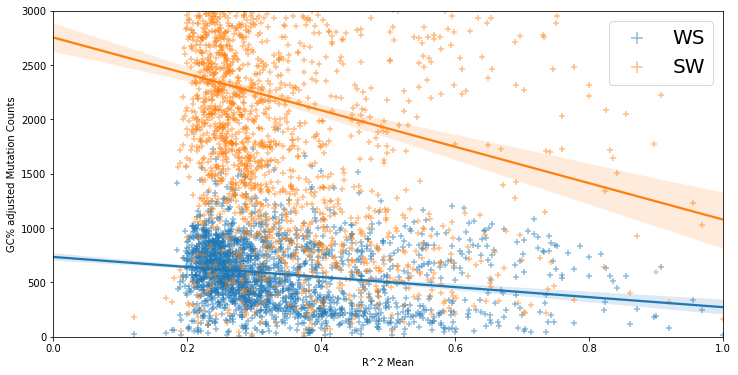

In [81]:
#plot WS and SW together
plt.figure(figsize=(12,6))
plt.ylim(0,3000)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_T_Adjusted'], marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_T_Adjusted'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('GC% adjusted Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [35]:
scipy.stats.linregress(x['r2_mean'], x['WS_T_Adjusted']) #WS is blue

LinregressResult(slope=-461.6072285347821, intercept=734.2285765848035, rvalue=-0.2017346782140083, pvalue=1.1188475208863109e-20, stderr=48.987508895681366)

In [36]:
scipy.stats.linregress(x['r2_mean'], x['SW_T_Adjusted']) #SW is orange

LinregressResult(slope=-1674.5945816478068, intercept=2752.740130516786, rvalue=-0.18840241303985694, pvalue=3.430652337777636e-18, stderr=190.80543562799437)

In [37]:
#Z-test for coefficients (slopes)
def Z_score(slope1, std_error1, slope2, std_error2):
    numerator = (slope1 - slope2)
    denominator = pow((pow(std_error1,2) + pow(std_error2,2)), 1/2)
    Z = (numerator) / (denominator)
    return Z

In [38]:
#Z_score for SW and WS, adjusted numbers
Z_score(-487.4643627632817, 50.747555732926905, -1691.774761691781, 194.24362089937904)
#result is 5.998658410170709
#two tailed p-value is 1.99e-9, reject null, observed difference is valid.

5.998658410170709

#### Unadjusted

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


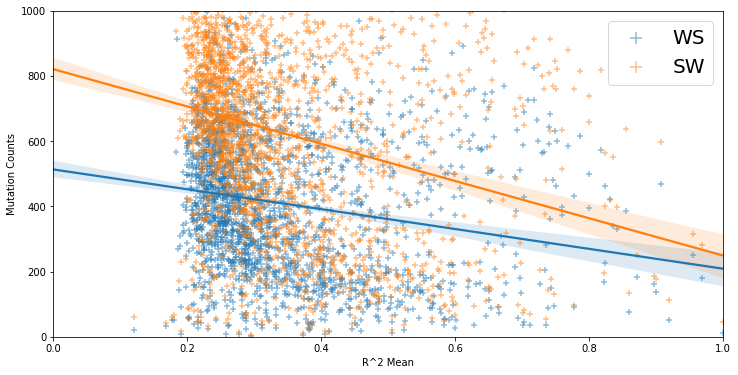

In [82]:
#unadjusted values
#plot WS and SW together
plt.figure(figsize=(12,6))
plt.ylim(0,1000)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_Total'], marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_Total'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [40]:
scipy.stats.linregress(x['r2_mean'], x['WS_Total']) #WS is blue

LinregressResult(slope=-304.3494499417676, intercept=513.1396598813749, rvalue=-0.1798032650429128, pvalue=1.1083398765937668e-16, stderr=36.39604121169277)

In [41]:
scipy.stats.linregress(x['r2_mean'], x['SW_Total']) #SW is orange

LinregressResult(slope=-571.1745603683817, intercept=820.4723755050503, rvalue=-0.25121297077926763, pvalue=1.627613833869185e-31, stderr=48.10463877925413)

In [89]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-304.3494499417676, 36.39604121169277, -571.1745603683817, 48.10463877925413)
#score 4.423356026798727
#p-value: 0.000009718, reject null

4.423356026798727

### Lambda, Odds Ratio

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


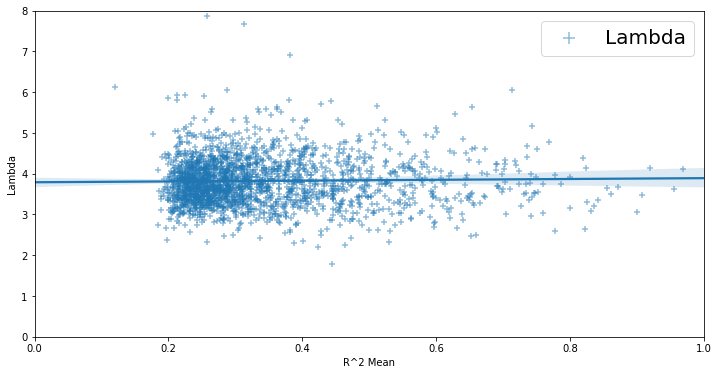

In [83]:
#SW/WS, adjusted
plt.figure(figsize=(12,6))
plt.ylim(0,8)
plt.xlim(0,1)

WST_adj = sns.regplot(x['r2_mean'], x['Lambda'], marker="+", scatter_kws={'alpha':0.5}, label='Lambda') 

plt.ylabel('Lambda')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [44]:
scipy.stats.linregress(x['r2_mean'], x['Lambda']) 

LinregressResult(slope=0.10029698141734507, intercept=3.7908802997677213, rvalue=0.019142107658600686, pvalue=0.38118554085436274, stderr=0.11450749450572932)

#### Unadjusted

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


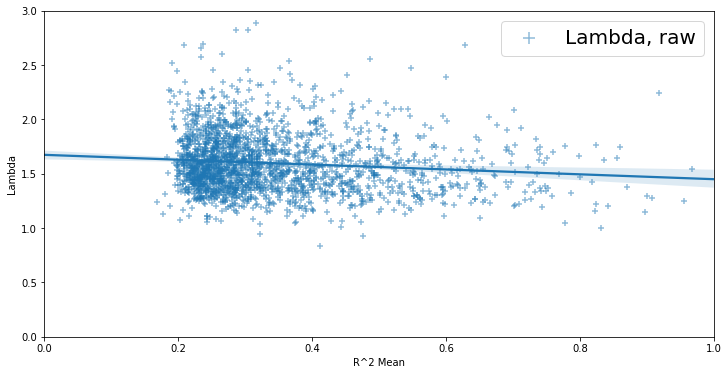

In [84]:
#unadjusted SW/WS
plt.figure(figsize=(12,6))
plt.ylim(0,3)
plt.xlim(0,1)

WST_adj = sns.regplot(x['r2_mean'], x['SW_Total']/x['WS_Total'], marker="+", scatter_kws={'alpha':0.5}, label='Lambda, raw') 

plt.ylabel('Lambda')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [46]:
scipy.stats.linregress(x['r2_mean'], x['SW_Total']/x['WS_Total']) 

LinregressResult(slope=-0.22409807652136352, intercept=1.6737484177730206, rvalue=-0.09951311915596252, pvalue=5.032111439635127e-06, stderr=0.0489792441179691)

### S2: The 10%, Rares (Note, unadjusted first)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


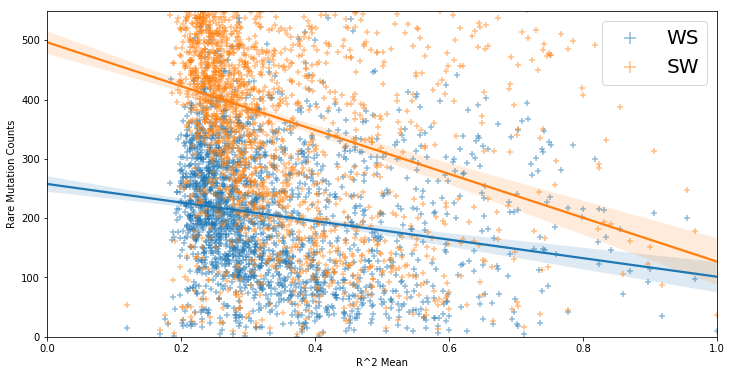

In [85]:
#Plot rare occuring mutations both direction (SW and WS)
plt.figure(figsize=(12,6))
plt.ylim(0,550)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_Rare'], marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_Rare'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('Rare Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [48]:
scipy.stats.linregress(x['r2_mean'], x['WS_Rare']) #WS is blue

LinregressResult(slope=-156.3121713769304, intercept=257.7175154992739, rvalue=-0.18878103970966426, pvalue=2.9324241348845976e-18, stderr=17.77337030619035)

In [49]:
scipy.stats.linregress(x['r2_mean'], x['SW_Rare']) #SW is orange

LinregressResult(slope=-369.5995672084842, intercept=496.63329409186787, rvalue=-0.28300037330671485, pvalue=7.034855147184409e-40, stderr=27.379952324000346)

In [74]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-156.3121713769304, 17.77337030619035, -369.5995672084842, 27.379952324000346)
#Z = 6.533973394189548
#p-value = 6.405e-11, reject null

6.533973394189548

#### Adjusted (Note, the order swtiches)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


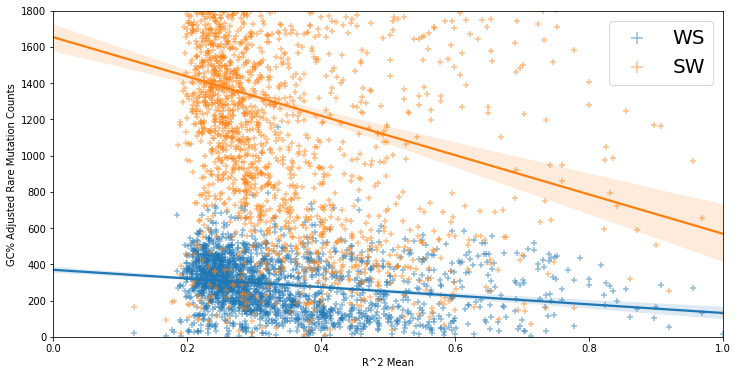

In [86]:
#adjusted for GC%
plt.figure(figsize=(12,6))
plt.ylim(0,1800)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_Rare']/(1 - x['GC_Content']), marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_Rare']/x['GC_Content'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('GC% Adjusted Rare Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [52]:
scipy.stats.linregress(x['r2_mean'], x['WS_Rare']/(1 - x['GC_Content'])) #WS is blue

LinregressResult(slope=-238.08174907285255, intercept=369.59965634814785, rvalue=-0.21134194126296052, pvalue=1.3961185774883596e-22, stderr=24.06764227985072)

In [53]:
scipy.stats.linregress(x['r2_mean'], x['SW_Rare']/x['GC_Content']) #SW is orange

LinregressResult(slope=-1084.6426887599052, intercept=1653.2042560083592, rvalue=-0.22023587684005486, pvalue=1.9842960547307076e-24, stderr=105.00682585428217)

In [75]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-238.08174907285255, 24.06764227985072, -1084.6426887599052, 105.00682585428217)
#Z = 7.858195678676494
#p-value = 3.897e-15, reject null

7.858195678676494

### S3: The 50%, Common (Note, unadjusted first)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


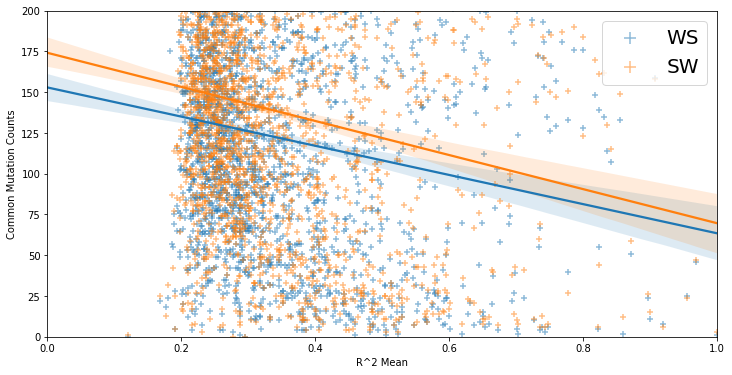

In [87]:
#Common, both directions
plt.figure(figsize=(12,6))
plt.ylim(0,200)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_Common'], marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_Common'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('Common Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [56]:
scipy.stats.linregress(x['r2_mean'], x['WS_Common']) #WS is blue

LinregressResult(slope=-89.42915500513821, intercept=152.91416750015327, rvalue=-0.15953820387697015, pvalue=2.0578576039833286e-13, stderr=12.095709120036611)

In [57]:
scipy.stats.linregress(x['r2_mean'], x['SW_Common']) #SW is orange

LinregressResult(slope=-104.4788070065201, intercept=174.1524590056835, rvalue=-0.17187513925162895, pvalue=2.3514202281591736e-15, stderr=13.089381012355068)

In [77]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-89.42915500513821, 12.095709120036611, -104.4788070065201, 13.089381012355068)
#Z = 0.8444232459755118
#p-value = 0.3984, fail to reject null

0.8444232459755118

#### Adjusted for GC content

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


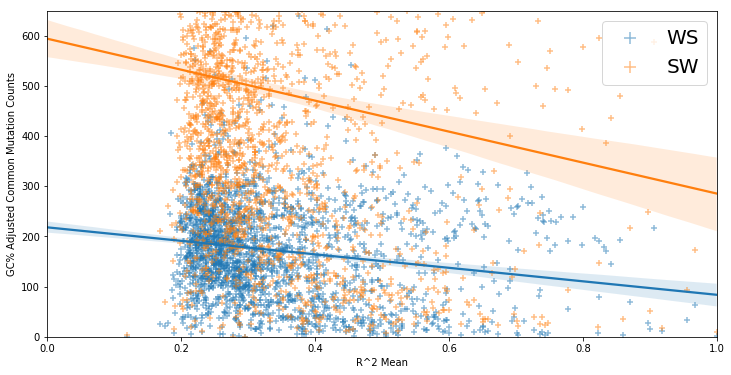

In [88]:
#adjusted for GC%
plt.figure(figsize=(12,6))
plt.ylim(0,650)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_Common']/(1 - x['GC_Content']), marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_Common']/x['GC_Content'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('GC% Adjusted Common Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [60]:
scipy.stats.linregress(x['r2_mean'], x['WS_Common']/(1 - x['GC_Content'])) #WS is blue

LinregressResult(slope=-134.4124150583511, intercept=218.15446714111954, rvalue=-0.17659614302869803, pvalue=3.8796923733933424e-16, stderr=16.37546777805637)

In [61]:
scipy.stats.linregress(x['r2_mean'], x['SW_Common']/x['GC_Content']) #SW is orange

LinregressResult(slope=-308.6510263900377, intercept=594.1647562755346, rvalue=-0.12754662147414875, pvalue=4.6730499403240086e-09, stderr=52.4629274192974)

In [80]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-134.4124150583511, 16.37546777805637, -308.6510263900377, 52.4629274192974)
#Z = 3.1703260148763035
#p-value = 0.001523, reject null

3.1703260148763035

### Two window comparison, Odds Ratio

In [64]:
#selecting for datapoints within the window or r2_mean 0.2-0.3 and 0.4-0.6
polistes_slice_1 = x[x['r2_mean'].between(0.2, 0.3, inclusive=True)];
polistes_slice_2 = x[x['r2_mean'].between(0.4,0.6, inclusive=True)];

In [65]:
polistes_slice_1.head()

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common,GC_Content,SW_T_Adjusted,WS_T_Adjusted,Lambda
0,PdomSCFr1.2-0173_100000,0.246808,0.079546,677,434,323,1434,394,199,146,135,0.289281,2340.287765,610.648928,3.832460
1,PdomSCFr1.2-0115_200000,0.251666,0.092593,832,626,385,1843,470,296,216,198,0.233172,3568.176352,816.350304,4.370889
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365,617,425,242,1284,398,222,127,104,0.336833,1831.766262,640.864573,2.858274
7,PdomSCFr1.2-0052_1000000,0.234617,0.061728,532,200,131,863,390,117,75,54,0.426084,1248.579328,348.483212,3.582897
13,PdomSCFr1.2-0115_500000,0.217277,0.090909,312,198,138,648,167,84,87,65,0.260267,1198.770853,267.663995,4.478641


In [66]:
polistes_slice_2.head()

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common,GC_Content,SW_T_Adjusted,WS_T_Adjusted,Lambda
6,PdomSCFr1.2-0033_1400000,0.403644,0.166667,811,578,611,2000,460,291,189,174,0.236842,3424.218417,757.379572,4.521139
16,PdomSCFr1.2-0066_700000,0.473945,0.259259,659,510,457,1626,391,272,146,131,0.287843,2289.443476,716.134101,3.196948
17,PdomSCFr1.2-0028_1100000,0.507439,0.444444,649,509,367,1525,376,247,153,169,0.215682,3009.057446,648.971593,4.636655
19,PdomSCFr1.2-0001_1200000,0.524973,0.444444,1106,724,512,2342,650,383,273,219,0.288083,3839.172938,1016.972314,3.775101
23,PdomSCFr1.2-0023_700000,0.532613,0.444444,1124,690,591,2405,685,332,224,224,0.306423,3668.131192,994.842770,3.687147


In [90]:
#categorizing data for Odds ratio, adjusted for GC%
#first for first window, denoted slice 1
sliced1_WS_R_adj = polistes_slice_1['WS_Rare'].sum();
sliced1_WS_C_adj = polistes_slice_1['WS_Common'].sum();

sliced1_SW_R_adj = polistes_slice_1['SW_Rare'].sum();
sliced1_SW_C_adj = polistes_slice_1['SW_Common'].sum();

In [92]:
#OR slice 1, WS/SW is:
(sliced1_WS_C_adj/sliced1_WS_R_adj)/(sliced1_SW_C_adj/sliced1_SW_R_adj)
#1.6270959290370026

1.6270959290370026

In [93]:
#Chi square, slice 1
chi_slice1 = np.array ([[sliced1_SW_R_adj, sliced1_SW_C_adj], [sliced1_WS_R_adj, sliced1_WS_C_adj]]) 
#array setup: SW-Rare,Common and WS-Rare,Common
chi2_contingency(chi_slice1)
#this returns chi-sqaure, p, degrees of freedom, and expected values in array
#(12168.411007836867, 0.0, 1, array([[421459.3104242, 185673.6895758], [266726.6895758, 117506.3104242]]))

(12168.411007836867, 0.0, 1, array([[421459.3104242, 185673.6895758],
        [266726.6895758, 117506.3104242]]))

In [94]:
#categorizing data for Odds ratio, adjusted for GC%
#second window, denoted slice 2
sliced2_WS_R_adj = polistes_slice_2['WS_Rare'].sum();
sliced2_WS_C_adj = polistes_slice_2['WS_Common'].sum();

sliced2_SW_R_adj = polistes_slice_2['SW_Rare'].sum();
sliced2_SW_C_adj = polistes_slice_2['SW_Common'].sum();

In [95]:
#OR slice 2, WS/SW is:
(sliced2_WS_C_adj/sliced2_WS_R_adj)/(sliced2_SW_C_adj/sliced2_SW_R_adj)
#1.5470135292224483

1.5470135292224483

In [96]:
#Chi square, slice 2
chi_slice2 = np.array ([[sliced2_SW_R_adj, sliced2_SW_C_adj], [sliced2_WS_R_adj, sliced2_WS_C_adj]]) 
#array setup: SW-Rare,Common and WS-Rare,Common
chi2_contingency(chi_slice2)
#this returns chi-sqaure, p, degrees of freedom, and expected values in array
#(2527.0749701551485, 0.0, 1, array([[102267.93236487,  48062.06763513],[ 67535.06763513,  31738.93236487]]))

(2527.0749701551485, 0.0, 1, array([[102267.93236487,  48062.06763513],
        [ 67535.06763513,  31738.93236487]]))